Method 1: Nielsen & Chuang

In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import UGate

def controlled_u_gate_1(n, theta, phi, lam):
    # Function: creates a multi-controlled U(θ, φ, λ) gate.
    # Input: number of control qubits n (int), & parameters of U-gate theta, phi, lam (float).
    # Output: A circuit with n control, (n-1) working, 1 target qubits, and a controlled-U gate.

    if n < 2:
        raise ValueError("n must be at least 2 to construct multi-control logic.")

    # Store U-gate from Qiskit library
    u = UGate(theta, phi, lam)

    # Create controlled-U gate with 1 control qubit
    cu = u.control(1)

    # Define registers
    control_reg = QuantumRegister(n, 'ctrl')        # control qubits
    working_reg = QuantumRegister(n - 1, 'work')    # ancilla/working qubits
    target_reg = QuantumRegister(1, 'tgt')          # target qubit
    qc = QuantumCircuit(control_reg, working_reg, target_reg)

    # Part 1: Create a series of CCX between control and working qubits
    qc.ccx(control_reg[0], control_reg[1], working_reg[0])
    for i in range(2, n):
        qc.ccx(control_reg[i], working_reg[i - 2], working_reg[i - 1])

    # Part 2: Apply controlled-U between the last working qubit and the target qubit
    qc.append(cu, [working_reg[n - 2], target_reg[0]])

    # Part 3: Reverse of Step 1
    for i in range(n - 1, 1, -1):
        qc.ccx(control_reg[i], working_reg[i - 2], working_reg[i - 1])
    qc.ccx(control_reg[0], control_reg[1], working_reg[0])

    return qc

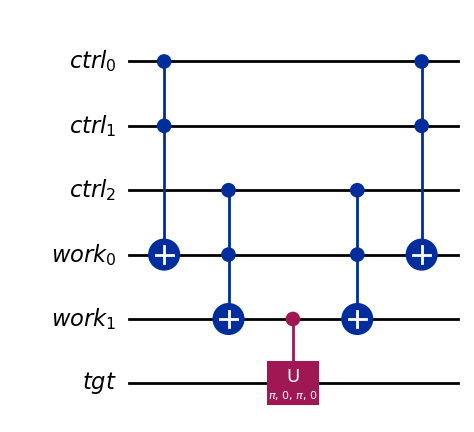

In [12]:
# Example: n=3 or CCCX-gate
qc3 = controlled_u_gate_1(3, np.pi, 0, np.pi)
qc3.draw(output='mpl')

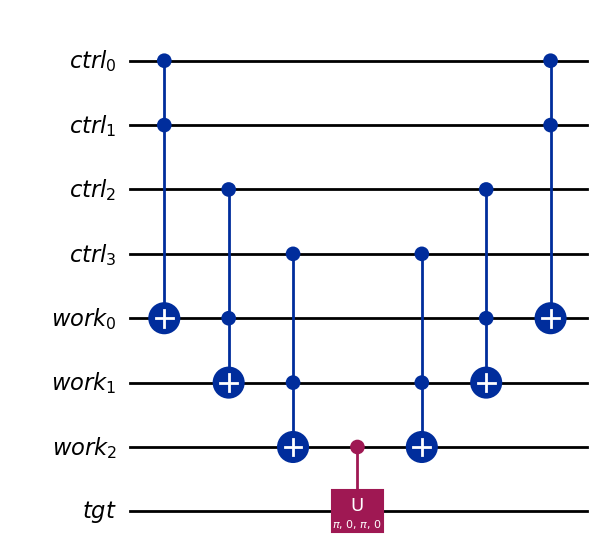

In [10]:
# Example: n=4 or CCCCX-gate
qc4 = controlled_u_gate_1(4, np.pi, 0, np.pi)
qc4.draw(output='mpl')

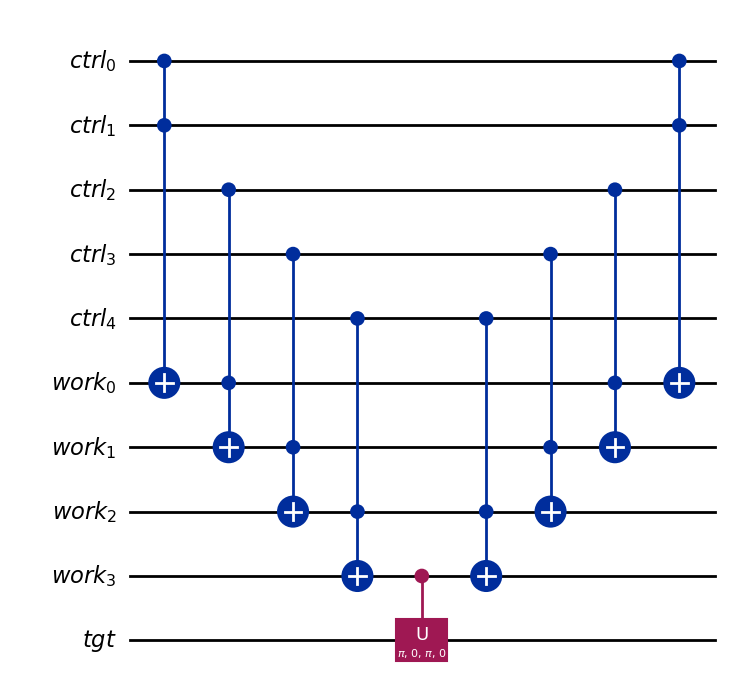

In [11]:
# Example: n=5 or CCCCCX-gate
qc5 = controlled_u_gate_1(5, np.pi, 0, np.pi)
qc5.draw(output='mpl')

Method 2: Barenco et al. (1995)

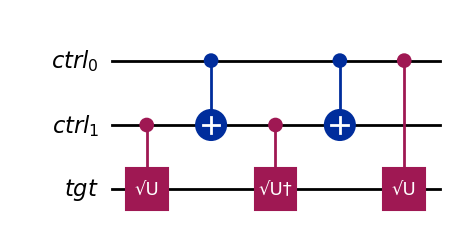

In [14]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import UGate
from qiskit.circuit.library import UGate, UnitaryGate
from qiskit.quantum_info import Operator
import scipy.linalg
import numpy as np


def CU_gate_2a(theta, phi, lam):
    # Get matrix of the U gate
    u = UGate(theta, phi, lam)
    u_matrix = Operator(u).data
    
    # Compute matrix square root using SciPy
    sqrt_u_matrix = scipy.linalg.sqrtm(u_matrix)
    
    # Convert back to a Qiskit gate
    v = UnitaryGate(sqrt_u_matrix, label="√U")
    v_dagger = UnitaryGate(sqrt_u_matrix.conj().T, label="√U†")
    
    # Create controlled-V gate
    cv = v.control(1)  
    cv_dagger = v_dagger.control(1)

    # Adjoint of controlled-V gate
    # cv_dagger = cv.inverse()

    control_reg = QuantumRegister(2, 'ctrl')   # control qubits
    target_reg = QuantumRegister(1, 'tgt')     # target qubit
    qc = QuantumCircuit(control_reg, target_reg)

    qc.append(cv, [control_reg[1], target_reg[0]])
    qc.cx(control_reg[0], control_reg[1])
    qc.append(cv_dagger, [control_reg[1], target_reg[0]])
    qc.cx(control_reg[0], control_reg[1])
    qc.append(cv, [control_reg[0], target_reg[0]])

    return qc 

 # Example:

qc = CU_gate_2a(np.pi, 0, np.pi)
qc.draw(output='mpl')

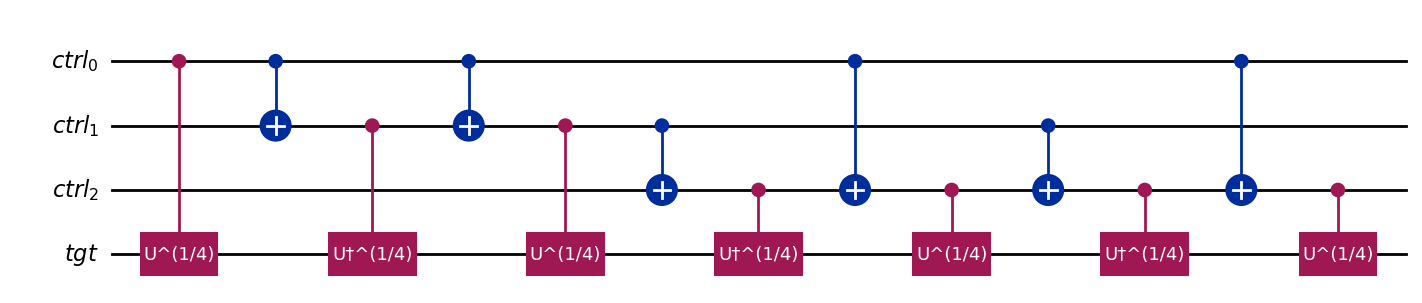

In [15]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import UGate
from qiskit.circuit.library import UGate, UnitaryGate
from qiskit.quantum_info import Operator
import scipy.linalg
from scipy.linalg import fractional_matrix_power
import numpy as np


def CU_gate_2b(theta, phi, lam):
    # Get matrix of the U gate
    u = UGate(theta, phi, lam)
    u_matrix = Operator(u).data

    u_fourth_root_matrix = fractional_matrix_power(u_matrix, 0.25)
    u_fourth_root_matrix_adj = fractional_matrix_power(u_matrix.conj().T, 0.25)


    v = UnitaryGate(u_fourth_root_matrix, label="U^(1/4)")
    v_dagger = UnitaryGate(u_fourth_root_matrix_adj, label="U†^(1/4)")
 
    # Create controlled-V gate
    cv = v.control(1)  
    cv_dagger = v_dagger.control(1)

    control_reg = QuantumRegister(3, 'ctrl')   # control qubits
    target_reg = QuantumRegister(1, 'tgt')     # target qubit
    qc = QuantumCircuit(control_reg, target_reg)

    qc.append(cv, [control_reg[0], target_reg[0]])
    qc.cx(control_reg[0], control_reg[1])
    qc.append(cv_dagger, [control_reg[1], target_reg[0]])
    qc.cx(control_reg[0], control_reg[1])
    qc.append(cv, [control_reg[1], target_reg[0]])
    qc.cx(control_reg[1], control_reg[2])
    qc.append(cv_dagger, [control_reg[2], target_reg[0]])
    qc.cx(control_reg[0], control_reg[2])
    qc.append(cv, [control_reg[2], target_reg[0]])
    qc.cx(control_reg[1], control_reg[2])
    qc.append(cv_dagger, [control_reg[2], target_reg[0]])
    qc.cx(control_reg[0], control_reg[2])
    qc.append(cv, [control_reg[2], target_reg[0]])

    return qc 

 # Example:

qc = CU_gate_2b(np.pi, 0, np.pi)
qc.draw(output='mpl')